# ![](img/logo.png)

# Boosting Machines

> __Alcance de esta lectura__
>
> * Conocer las técnicas de boosting como un ensambles secuenciales.
> * Identificar las diferencias de optimización entre AdaBoost y Gradient Boosting.
> * Implementar AdaBoost y Gradient Boosting con `scikit-learn`.
> * Identificar e implementar ajuste de hiperparámetros en algoritmos de Boosting.


## Motivación

Tomemos el punto de partida sobre el _no free lunch theorem_ (Wolpert y Macready, 1997): __No existe un algoritmo que presente una solución satisfactoria para todos los problemas.__ Cada método tiene sus virtudes y defectos en un conjunto de datos específico. El problema es que debemos testear una serie de algoritmos candidatos para ver cuál se desempeña de mejor manera. Esto presenta varias aristas:

1. Necesidades de la Industria: Una de las particularidades de los algoritmos aplicados en la industria es el hecho que deben cumplir con ciertos objetivos impuestos por el líder de proyecto. La cantidad y variedad de datos tiene un costo impositivo en el tiempo de ejecución de los modelos, que puede ser restrictivo para la empresa.
- Pureza de los datos: Los datos registrados presentan una variedad de formatos, registrando atributos numéricos y categóricos que necesitan de preprocesamiento. En la medida que el registro aumento, la labor de preprocesamiento y selección de atributos relevantes puede ser restrictiva para el objetivo de trabajo.
- Interpretabilidad de los modelos: El objetivo de todo modelo es realizar una simplificación de la realidad. Mientras que en algunos como las Máquinas de Soporte Vectorial no facilitan la interpretación, existen otros modelos como los basados en regresión o árboles de decisión que son informativos sobre el impacto de los atributos en el vector objetivo.

Un algoritmo que se pueda implementar sin mayor preprocesamiento o modificación de hiperparámetros se conoce como _"off the shelf"_. De todos los algoritmos vistos, probablemente los Árboles de Decisión son aquellos cumplen de mejor manera los requerimientos _"off the shelf"_. Son rápidos de construír y producen modelos interpretables. Son estables ante la inclusión de atributos mixtos e invariantes frenet a las transformaciones de éstos. Dado que depuran los atributos entre relevantes e irrelevantes, son estables frente atributos no informativos (Hastie et al, 2009).

El principal problema de los árboles tiene que ver con su tendencia al overfit. Como el proceso de segmentación de nodos depende de un problema de optimización local en los atributos, fallan en mayor medida en su capacidad de generalización en nuevos conjuntos de datos. 

Hasta el momento conocemos dos grandes tipos de algoritmos. Por un lado tenemos un modelo donde se entrena en una instancia específica, como las Máquinas de Soporte Vectorial, la Regresión Logística, Naive Bayes y Árboles de Decisión. Su principal desventaja es el hecho que no tenemos certeza sobre su capacidad de generalización sin la necesidad de implementar técnicas de validación cruzada y ajuste de hiperparámetros.

![](img/adaboost_behavior.svg)

También sabemos que existe un segundo tipo de algoritmo que se implementa mediante el _ensamble_ de múltiples modelos para obtener un aproximado en base a algún sistema de votación. Dentro de este, existen aquellos que son __paralelos__, como Random Forest y Bagging. El problema con ellos es que son computacionalmente ineficientes dado que ejecutan todos los modelos, y posteriormente los promedian. En esta sesión aprenderemos sobre los algoritmos basados en _Boosting_, que coleccionan el resultado de modelos entrenados en múltiples instancias en algo conocido como __entrenamiento secuencial__ (Bishop, 2006). La principal ventaja de éstos es que permiten el ajuste iterado _in situ_ de cada uno de los modelos.

# AdaBoost: Boosting Adaptativo

> Por motivos pedagógicos, la exposición del algoritmo se concentra en el caso de clasificación. Para aquellos casos donde se entrenan regresores débiles, la intuición es similar.

El algoritmo más conocido de Boosting es `AdaBoostM.1` de Freund y Schapire (1997). Consideremos el siguiente problema de clasificación binario, donde nuestro vector objetivo se expresa como $y \in \mathcal{Y}= \{-1, 1\}$. Dado un conjunto de atributos $\mathbf{X}$, un clasificador específico $h(X)$ produce una predicción en una de las dos clases. Podemos obtener la tasa de error a lo largo de todos los clasificadores mediante:

$$
\bar{\varepsilon}_{i} = \frac{\sum_{i=1}^{N}\mathbb{I}\big(y_{i} \neq h(x_{i})\big)}{N}
$$

y estimar la esperanza del error en el conjunto de clasificadores como $\mathbb{E}_{X\mathcal{Y}}\mathbb{I}\big(\mathcal{Y} \neq h(\mathbf{X})\big)$.

Resulta que los algoritmos de Boosting hacen uso de clasificadores débiles. Un clasificador débil es aquél cuyas prediciones son marginalmente mejores que la de un clasificador aleatorio. Para efectos prácticos, Freund y Schapire (1997) consideran que un árbol de decisión con un solo nodo de partición es el punto de partida más aceptable para generar un clasificador débil.

El objetivo de Boosting es aplicar de forma __secuencia__ un algoritmo de clasificación débil de manera iterativa. Así generamos una serie de clasificadores débiles de manera

$$
\mathcal{H}_{m}(\mathbf{X}) = 1, 2, \cdots, M
$$

La predicción de clases para nuevas observaciones se realiza mediante mayoría simple de votos ponderados de la siguiente forma:

$$
\mathcal{H}_{m} = \textsf{sign}\Big(\sum_{i=1}^{M}\alpha_{m}h_{m}(x)\Big)
$$

Los votos de cada clasificador $h_{m}$ se pondera mediante $\alpha_{m}$ que permiten ajustar la contribución de cada clasificador en el ensamble. 


> ### Algoritmo
>
> 1. El primer paso es la inicialización de los ponderadores observacionales. Cada observación $x_{i} \in \mathbf{X}$ tendrá un ponderador $w_{i}$. En la primera iteración, el ponderador asignará un peso equiprobable de forma $w_{i} = 1/N$ donde $N$ es la cantidad de observaciones.
> - Para cada clasificador débil en nuestro ensamble $m \in M$:
    - Entrenar el clasificador débíl $h_{m}(x)$ en los datos de entrenamiento previamente ponderados.
    - Con el clasificador débil, podemos obtener su error de clasificación específico  
>   $$
        \bar{\varepsilon}_{i} = \frac{\sum_{i=1}^{N}w_{i}\mathbb{I}\big(y_{i} \neq h_{m}(x_{i})\big)}{\sum_{i=1}^{N}w_{i}}
    $$
    donde sumamos y ponderamos aquellas observaciones predichas __incorrectamente__ $\Big(\mathbb{I}(y_{i} \neq h_{m}(x_{i})\Big)$.
>   - Con la tasa de error específica del clasificador débil, estimamos la chance del error con $\alpha_{m}=\textsf{log}\big((1- \bar{\varepsilon}_{m})/\bar{\varepsilon}_{m})\big) $.
    Ésta chance permitirá ponderar la contribución de cada clasificador. El objetivo de esta fase es asginar un mayor peso a aquellas observaciones incorrectas, forzando la identificación de clasificadores correctos para éstas.   
>   - Antes de proseguir con el siguiente clasificador débil, se actualiza el peso observacional $w_{i} \leftarrow w_{i} \cdot \textsf{exp}\Big[\alpha_{m}\cdot\mathbb{I}(y_{i}\neq h_{m}(x_{i})\Big] \quad \forall i \in N$.
> - Resumir el proceso de cada clasificador débil mediante $\mathcal{H}(x) = \textsf{sign}\Big(\sum_{i=1}^{M}\alpha_{m}h_{m}(x)\Big)$.

Las modificaciones en cada paso de boosting consisten en aplicar ponderadores $w_{1}, w_{2}, \cdots, w_{n}$ a cada observación en el conjunto de entrenamiento. En la primera iteración todos los ponderadores tienen un peso equiprobable de $w_{i} = 1/N$, de manera tal que en la primera iteración el modelo entrenado no dista de Bagging o Random Forest.

Para las iteraciones posteriores $m \in M$, los ponderadores de observaciones se modifican y el algoritmo de clasificación se vuelve a aplicar a las observaciones ponderadas. En cada paso $m$, las observaciones clasificadas incorrectamente por el clasificador anterior $h_{m-1}(x)$ aumentan sus ponderadores, mientras que las observaciones clasificadas correctamente disminuyen su ponderador. 

En la medida que las iteraciones aumentan, las observaciones que son difíciles de clasificar reciben una mayor influencia. En cada sucesión, los clasificadores se ven forzados a concentrarse en las clasificaciones incorrectas.

## Ejemplo: Identificando correos no deseados

Para ejemplificar el uso de Adaptative Boosting dentro de Python, implementaremos un modelo para predecir correos no deseados en una casilla. El ejemplo proviene de _Hastie, T; Tibshirani, R; Friedman, J. 2009. The Elements of Statistical Learning: Data Mining, Inference and Prediction._ Los datos fueron donados por George Forman (gforman at nospam hpl.hp.com). 

En estos datos se busca predecir si un mail específico corresponde o no a spam dadas ciertas características del texto. Dentro de ellas se encuentran 48 campos que cuentan la frecuencia de ciertas palabras, siguiendo la nomenclatura `word_freq_<nombrepalabra>`. También se incluye la extensión del mail, la cantidad de símbolos y si menciona el nombre de George (el dueño de los mails).

Partamos por inspeccionar los datos y extraer las principales características. Observamos que aproximadamente el 40% de los mails contenidos se identificaron como correo no deseado. 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lec9_graphs as afx
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
df = pd.read_csv('spamdata_esl_colnames.csv').drop(columns='Unnamed: 0')

0    0.605955
1    0.394045
Name: spam, dtype: float64


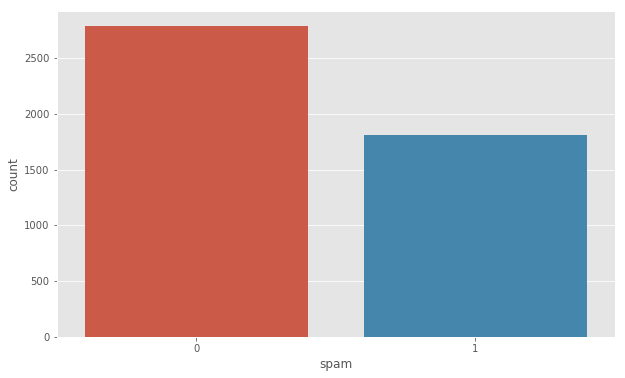

In [3]:
print(df['spam'].value_counts('%'))
sns.countplot(df['spam']);

Observemos la ocurrencia de algunos atributos entre mails clasificados como spam o no. En la figura izquierda comparamos la frecuencia entre ciertas palabras para ambos grupos. En la figure derecha calcularmos el diferencial entre ambos grupos. Observamos que palabras como "_you_",  "_your_", "_free_", y "our" presentan una prevalencia en los mails clasificados como spam. En contraparte, las palabras más comunes entre los mails clasificados como no Spam son aquellos que hacen referencia a información específica del usuario, como su nombre (George) y dónde trabaja (HP).

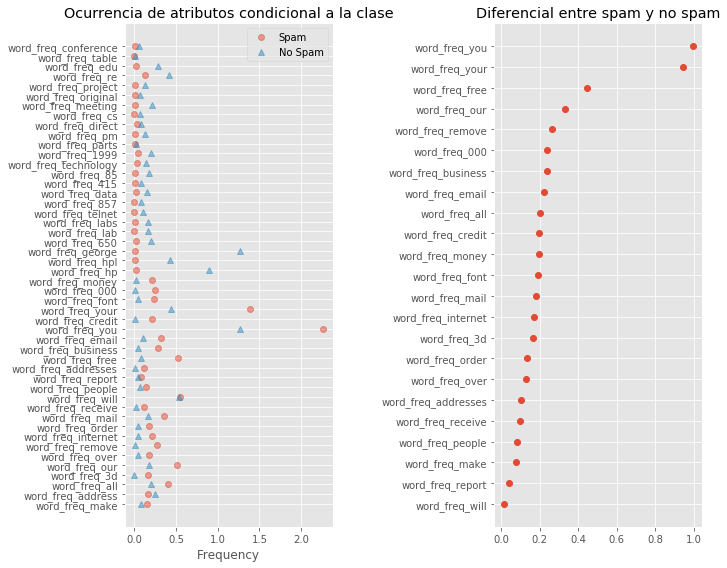

In [4]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
# separamos las columnas que comiencen con word_freq
exclude_df = df.filter(regex='word_freq_*')
exclude_df['spam'] = df['spam']
# calculamos la media por grupo de cada columna
store_means_no_spam = exclude_df.query('spam == 0').drop(columns='spam').apply(lambda x: np.mean(x), axis=0)
store_means_spam = exclude_df.query('spam == 1').drop(columns='spam').apply(lambda x: np.mean(x), axis=0)
plt.plot(store_means_spam, store_means_spam.index, 'o', alpha=.5, label="Spam")
plt.plot(store_means_no_spam, store_means_no_spam.index, '^', alpha=.5, label="No Spam")
plt.xlabel('Frequency')
plt.title('Ocurrencia de atributos condicional a la clase')
plt.legend();
plt.subplot(1, 2,2)
store_diff = store_means_spam - store_means_no_spam # calculamos diferencial
store_diff = store_diff[store_diff > 0].sort_values() # ordenamos y mantenemos sólo los positivos
plt.plot(store_diff, store_diff.index, 'o')
plt.title('Diferencial entre spam y no spam')
plt.tight_layout()

## Entrenando un clasificador Adaptativo con `sklearn.ensemble.AdaBoostClassifier`

La implementación del algoritmo se encuentra en `sklearn.ensemble.AdaBoostClassifier`. De manera adicional, importaremos las funciones clásicas para generar muestras de validación y entrenamiento, así como un reporte de métricas de clasificación. Los pasos para implementarlo seguiremos los mismos pasos de cualquier algoritmo `sklearn`

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'word_freq_make':'capital_run_length_total'],
                                                    df['spam'], test_size=.33, random_state=11238)

Adaptative Boosting aprovecha múltiples clasificadores débiles, donde su variante más común es un árbol de decisión con una profundidad mínima. En la literatura se conoce como un "decision stump". Si bien éste es el modelo que se implementa por defecto en la clase `AdaBoostClassifier`, generaremos un objeto con éstas características por motivos expositivos.

En esta primera iteración, mantendremos la cantidad de hiperparámetros de `AdaBoostClassifier` al mínimo. Esto implica definir una semilla pseudoaleatoria para facilitar la replicación de resultados, así como un entrenamiento con decision stump con fines comparativos

In [1]:
# Entrenamos el decision stump
decision_stump = DecisionTreeClassifier(max_depth=1, random_state=11238).fit(X_train, y_train)
# Entrenamo el clasificador con adaptive boosting
adaboost_classifier = AdaBoostClassifier(base_estimator=decision_stump, random_state=11238).fit(X_train, y_train)

NameError: name 'DecisionTreeClassifier' is not defined

Para efectos prácticos, guardaremos las clases predichas y la probabilidad de clase predicha para el modelo AdaBoost.

In [7]:
# guardamos las predicciones de ambos modelos
tree_y_hat = decision_stump.fit(X_train, y_train).predict(X_test)
adaboost_y_hat = adaboost_classifier.fit(X_train, y_train).predict(X_test)
adaboost_pr = adaboost_classifier.fit(X_train, y_train).predict_proba(X_test)
# generamos el reporte
print("Decision Stump:")
print(classification_report(y_test, tree_y_hat, digits=3))
print("\n\nAdaptative Boosting Classifier:")
print("Cantidad de Estimadores:", adaboost_classifier.n_estimators, "\n")
print(classification_report(y_test, adaboost_y_hat, digits=3))

Decision Stump:
             precision    recall  f1-score   support

          0      0.844     0.793     0.817       912
          1      0.715     0.779     0.745       607

avg / total      0.792     0.787     0.789      1519



Adaptative Boosting Classifier:
Cantidad de Estimadores: 50 

             precision    recall  f1-score   support

          0      0.939     0.950     0.944       912
          1      0.923     0.908     0.915       607

avg / total      0.933     0.933     0.933      1519



Inspeccionado los resultados del decision stump, observamos que el modelo tiene un desempeño 29% superior que un clasificador débil (medido con f1-score). Ésto es bastante bueno, dado que no estamos forzando las particiones del árbol en gran manera. Aún así, cabe destacar que el desempeño del modelo es mejor en la predicción de aquellos mails que __no son spam__. 

Por defecto, al entrenar un modelo con AdaBoost y un total de 50 árboles con un mínimo de profundidad, el desempeño 43% superior que un clasificador aleatorio y un 15% superior que un decision stump (medido con f1-score). Otro aspecto a consdierar es que el desempeño condicional a cada clase predicha disminuyó sus brecha, teniendo un desempeño mucho más homogeneo a lo largo de todas las clases.

## ¿Qué pasa tras bambalinas de AdaBoost?

> __Caveat:__ Para efectos prácticos de la lectura, el problema expositivo con los gráficos se desarrolla con el entrenamiento de dos atributos. Para detalles técnicos, pueden hacer uso del archivo auxiliar `lec9_graphs.py`.

Para entender el proceso de Adaptative Boosting debemos considerarlo dentro del contexto de los ensambles. ¿Qué es lo que sabemos hasta este momento respecto a los ensambles?
1. Sabemos que con los árboles de decisión producen soluciones optimizadas de manera local en función de los atributos. Un problema de esto es que las soluciones puede que no sean generalizables a nuevos conjuntos de datos. 
- Mediante el principio de Bagging y su aplicación más conocida, Random Forests, buscamos reducir la fuerte tendencia de los árboles de decisión al overfitting.
- Mientras que Bagging se basa en el principio de Boostraping para realizar muestras con reemplazo, Random Forest también implementa selección aleatoria de atributos para reducir la correlación entre árboles.
- Ambos algoritmos funcionan como modelos __paralelos__: optimizan la función de pérdida posterior al entrenamiento de cada modelo.

Dado que tenemos una cantidad de árboles con profundidad mínima definida _ex ante_ de entrenar el modelo, buscamos reforzar el comportamiento de manera secuencial del ensamble. Partamos por visualizar el efecto de cada uno de los árboles. Para ello implementaremos la función `afx.adaboost_weak_learner_behavior`, donde observamos la partición realizada en 6 árboles elegidos aleatoriamente. Cada árbol estimado presenta una partición distinta, la cual conlleva a una tasa de error marginalmente superior a un clasificador aleatorio.

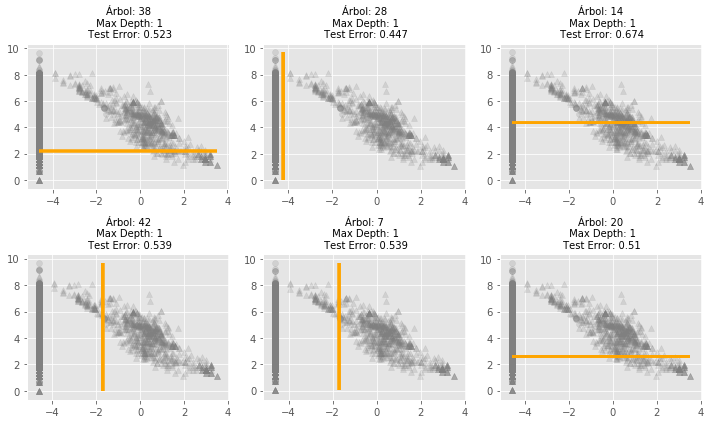

In [36]:
np.random.seed(42)
afx.adaboost_weak_learner_behavior()

Dado que en Adaptative Boosting buscamos hacer más evidentes los errores para actualizar los ponderadores en la siguiente iteración. En este ejemplo, el árbol 11 presentará una ponderación mayor en las observaciones incorrectas. 

El algoritmo se considera __adaptativo__ porque va de manera secuencial entregando más información sobre cada modelo, acumulándola en la misma superficie de respuesta. De esta manera, Al entrenar una cantidad suficiente de estimadores estaremos perfilando de manera adecuada las particiones existentes en nuestra matriz de atributo. En la figura generada con `afx.adaboost_adaptive_behavior` se demuestra el comportamiento de una concatenación de árboles con un mínimo de profundidad.

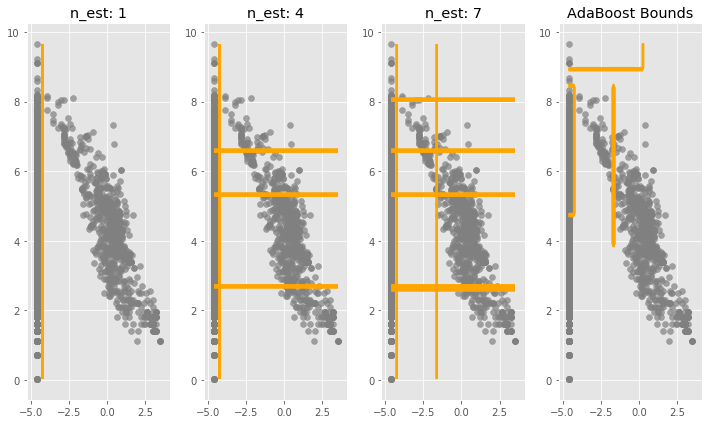

In [37]:
afx.adaboost_adaptive_behavior()

El comportamiento de AdaBoost es identificar manera progresiva en qué datos debe poner atención. En la figura se aprecia que en la medida que la cantidad de estimadores aumenta, la cantidad de particiones también lo hace. Resulta que la ventaja de AdaBoost es que permite reducir esta cantidad saturada de árboles a una superficie de respuesta más flexible.

### La ponderación observacional en Adaptive Boosting

Al inicio de la lectura mencionamos que una de las virtudes del algoritmo AdaBoost es la capacidad de ponderar de manera secuencial las observaciones correctas e incorrectas. Para lograr esto, debemos extraer las predicciones en cada una de las iteraciones del modelo. La primera parte implica evaluar de forma parcelada el comportamiento de las clases predichas en cada estimador. Esto lo logramos con la opción `sklearn.ensemble.AdaBoostClassifier().staged_predict_proba()`, donde ingresamos la matriz de atributos de validación.

In [38]:
# iniciamos un array vacío
store_pr = []
for i in adaboost_classifier.staged_predict_proba(X_test):
    # guardamos los resultados de cada estimador
    store_pr.append(i)

La lista `store_pr` registra las predicciones para los 1519 registros de validación. Nuestro experimento es evaluar el patrón de predicción de las probabilidades de clase en un conjunto aleatorio de registros. 

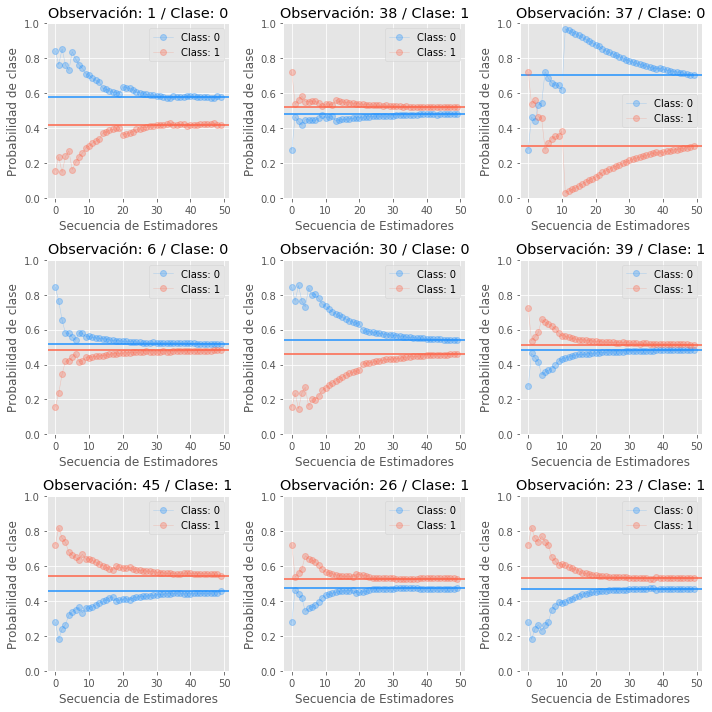

In [39]:
# fijamos el tamaño del gráfico
plt.figure(figsize=(10, 10))
# seteamos una semilla pseudo aleatoria para replicación
np.random.seed(11238)
# Para cada uno de los números aleatorios a elegir
for index, value in enumerate(np.random.randint(1, 50, size=9)):
    plt.subplot(3, 3, index + 1)
    # perfilamos el comportamiento
    mlc = afx.adaboost_classification_behavior(store_pr, adaboost_pr, value)
    plt.title(f'Observación: {value} / Clase: {mlc}')
    plt.ylim((0, 1))
    plt.ylabel('Probabilidad de clase')
    plt.xlabel('Secuencia de Estimadores')
    plt.tight_layout()

Algunos aspectos a considerar en la figura creada:

1. A grandes rasgos, la principal característica de las probabilidades predichas en cada modelo es su tendencia a estabilizarse en la medida que la secuencia de estimadores aumenta. 
- Existen casos como  37, donde en las primeras iteraciones las probabilidades predichas son inestables. Algunas veces se posicionan con valores altos (situación que ocurre en los primeros iteradores). Casos como este son la principal motivación de AdaBoost. Se observa un aumento substancial en la ponderación asignada, representada con una curva más pronunciada que se suaviza de forma secuencial en la medida que aumentan los estimadores.
- Otros casos, como la observación 6 presenta una comportamiento más estable, que significa que los pesos observaciones tuvieron un menor rol.

### Comportamiento de AdaBoost en la exactitud general

Otra característica deseable de Adaptive Boosting es el hecho que presenta muy buenos resultados sin necesidad de modificar hiperparámetros. Para ello graficaremos la exactitud en las predicciones de clase a lo largo de la secuencia de estimadores. Tomemos la primera iteración, que tiene un valor de .78. Éste es idéntico al valor en la exactitud del decision stump. En las posteriores iteraciones de la secuencia, la exactitud se dispara optimizándose en 38.

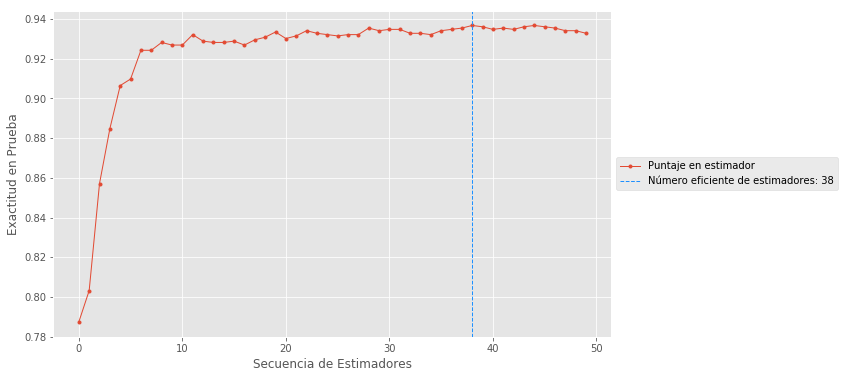

In [40]:
store_acc = np.empty(adaboost_classifier.n_estimators)
for index, value in enumerate(adaboost_classifier.staged_score(X_test, y_test)):
    store_acc[index] = value
    
# extraemos la posición óptima de estimadores
signal_optim = np.where(store_acc == np.max(store_acc))[0][0]
plt.plot(store_acc, '.-', lw=1, label='Puntaje en estimador')
plt.axvline(signal_optim, color='dodgerblue',
            lw=1, linestyle='--',
            label=f'Número eficiente de estimadores: {signal_optim}')
plt.xlabel('Secuencia de Estimadores')
plt.ylabel('Exactitud en Prueba')
plt.legend(loc='center left', bbox_to_anchor=(1, .5))

## Hiperparámetros asociados a AdaBoost

Resulta que hasta ahora entendemos la capacidad aditiva de AdaBoost para incorporar más información de manera secuencial a nuestro ensamble. Podríamos caer en la avaricia e intentar entrenar ensambles con una cantidad redundante de estimadores basales. Como indica la intuición, los problemas asociados a esto van de la mano con una posible falla en la generalización del ensamble en nuevos conjuntos de datos. Para ello debemos modificar hiperparámetros. La implementación ` sklearn.ensemble.AdaBoostClassifier` tiene en consideración dos elementos a considerar: Cantidad de modelos y tasa de aprendizaje.

### Tipo y cantidad de modelos

Esta parte es similar respecto a los modelos paralelos: debemos definir un clasificador basal débil. Por defecto la implementación de `sklearn.ensemble.AdaBoostClassifier` entrena árboles de decisión con un mínimo de profundidad, conocidos como __clasificadores débiles__. Esta opción generalmente no se modifica dado que la implementación original de `AdaBoost.M1` (Freund y Schapire, 1996) se diseño con éste árbol.

Con este modelo definido, debemos declarar la cantidad de éstos a implementar. La implementación de `sklearn.ensemble.AdaBoostClassifier` termina de forma prematura el proceso de entrenamiento en caso que se genere un ajuste perfecto en éste.

La figura generada con `afx.n_estimators_hyperparams()` evalúa el modelo baseline que definimos arriba en la lectura. El gráfico de arriba presenta la evolución de la tasa de error ($1 - \textsf{Exactitud}$) en los conjuntos de entrenamiento y validación, condicional a la cantidad de estimadores dentro de nuestro ensamble. Un aspecto clásico es el hecho que la curva de entrenamiento tenderá a disminuir de forma progresiva la tasa de error, mientras que la curva de validación aumentará cuando la cantidad de estimadores supera los 600. Esto genera indicios de overfitting a partir de éste punto.

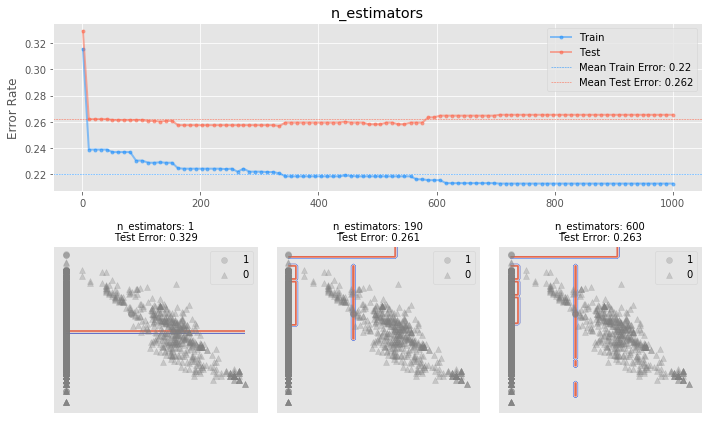

In [41]:
afx.n_estimators_hyperparams()

En los cuadros de abajo presentamos el efecto de la cantidad de clasificadores débiles en nuestra superficie de respuesta. Cuando la cantidad de estimadores es igual a 1, la superficie de respuesta particionada es exactamente igual a un decision stump. La superficie de respuesta cuando aumentamos la cantidad de clasificadores débiles tiende a delimitarse de forma adecuada en patrones (a grandes rasgos las particiones siguen las mismas tendencias). La principal diferencia es el indicio de overfitting cuando la cantidad de estimadores basales es de 600 o más. Para este último caso, observamos que las particiones de la superficie de respuesta tienden a realizarse sobre los mismos rangos.

### Tasa de Aprendizaje

La tasa de aprendizaje (o `learning_rate` en la función `sklearn.ensemble.AdaBoostClassifier`) permite regularizar la influencia de cada clasificador basal en los ponderadores observacionales $w_{i}$. Valores bajos de la tasa de aprendizaje conllevan a que la actualización de los ponderadores observaciones (ya sea incremento o decrecimiento) sea más lenta. En este escenario, el tiempo de entrenamiento del modelo será más lento. Lo inverso sucede cuando la tasa de aprendizaje es substancialmente alta.

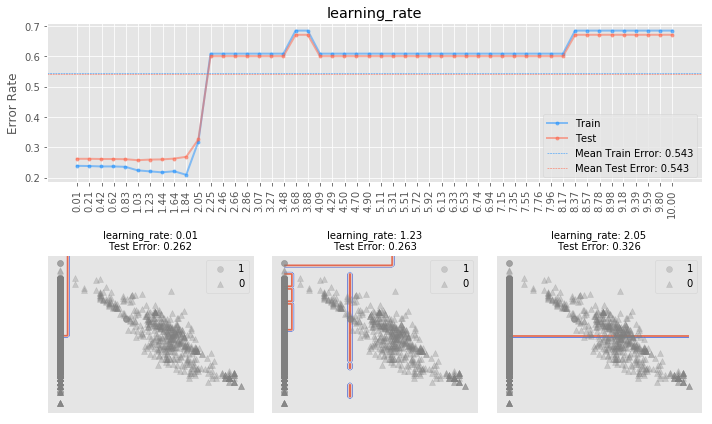

In [42]:
afx.learning_rate_hyperparams()

El efecto de la tasa de aprendizaje se ejemplifica con la figura `afx.learning_rate_hyperparams`. Uno de los primeros puntos a considerar es el hecho que el comportamiento de las tasas de error condicional a la tasa de aprendizaje es relativamente similar en el rango de evaluación. De hecho, cuando evaluamos el modelo con una tasa superior a 2.25, el comportamiento de ambas curvas se dispara en la tasa de error y ambas son idénticas. 

Entre el rango de 0.01 y 2.05, el comportamiento de la superficie de respuesta es substancialmente distinto. Cuando la tasa de aprendizaje es muy baja, la solución que entrega es insuficiente en el conjunto de datos. Lo mismo ocurre cuando la tasa es muy alta. Resulta que el learning rate que presente un menor error se va a asemejar a la superficie de respuesta similar a la desarrollada con un adaboost.

## Comparación AdaBoost con múltiples modelos

En el siguiente experimento evaluaremos el desempeño de AdaBoost con múltiples modelos. Una de las condiciones base de la simulación es la comparación de múltiples clasificadores en sus valores basales. Los modelos a desarrollar son:

- `tree_decision_stump` $\leadsto$ un árbol de decisión con sólo una partición.
- `tree_model` $\leadsto$ Un árbol de decisión sin poda.
- `rf_model` $\leadsto$ Un ensamble de árboles aleatorios. Para efectos de simulación, cada árbol será un decision stump.
- `adaboost_model` $\leadsto$ Un ensamble secuencial de árboles. Para efectos de simulación, cada árbol entrenado será un decision stump.

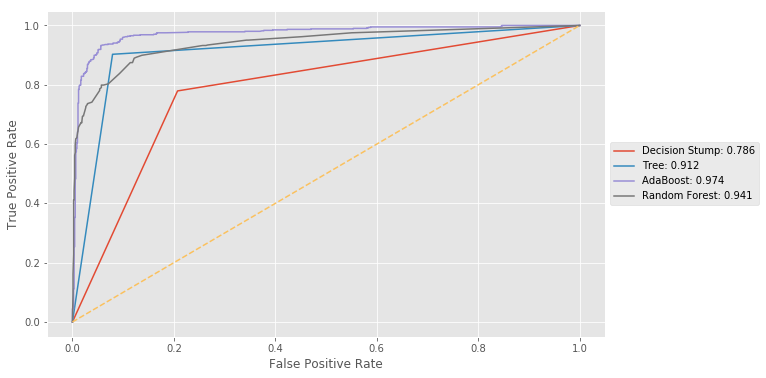

In [43]:
from sklearn.ensemble import RandomForestClassifier

# imitamos el comportamiento de árboles débiles con un decision stump
tree_decision_stump = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
tree_model = DecisionTreeClassifier().fit(X_train, y_train)
rf_model = RandomForestClassifier(max_depth=1).fit(X_train, y_train)
adaboost_model = AdaBoostClassifier(base_estimator = tree_decision_stump, random_state=11238).fit(X_train, y_train)

afx.plot_roc(model=tree_decision_stump, y_true= y_test, X_test=X_test, model_label = "Decision Stump")
afx.plot_roc(model=tree_model, y_true= y_test, X_test=X_test, model_label = "Tree")
afx.plot_roc(model=adaboost_model, y_true= y_test, X_test=X_test,model_label="AdaBoost")
afx.plot_roc(model=rf_model,y_true= y_test, X_test=X_test, model_label="Random Forest")
plt.plot([0, 1], ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, .5));

Manteniendo los algoritmos con las modificaciones mínimas de hiperparámetros, se observa que Adaptive Boosting entrega un mejor desempeño medido como el área debajo de la curva ROC. Quizás el modelo que más se asemeja en desempeño es Random Forest. También hay que destacar el hecho que el decision stump implementado presenta un desempeño 28% superior al clasificador aleatorio, considerando que ésta es la implementación más básica. 

---

## Gradient Boosting 

> __Caveat__: Tanto AdaBoost como Gradient Boosting obedecen a la estrategia de ponderar la muestra de entrenamiento en cada iteración, de manera de suavizar los errores. Dado que todavía no discutimos técnicas de optimización basadas en gradientes, pueden saltarse ésta parte si sienten que la matemática es demandante.

La otra gran variante de ensamble secuencial a implementar es Gradient Boosting. A diferencia de Adaptive Boosting donde cada secuencia del modelo se entrenaba ponderando observaciones, con Gradient Boosting entrenamos cada secuencia del modelo __en base a los errores residuales del modelo anterior__. Dado que estaremos entrenando en función al gradiente, parte importante del algoritmo es la elección de la función de pérdida a minimizar

$$
f_{0}(\mathbf{x}) = \underset{\gamma\in\Gamma}{\textsf{argmin}}\sum_{i=1}^{N}\ell(y_{i}, \phi(\mathbf{x}_{i}, \gamma))
$$

Resulta que el error a minimizar en ensambles secuenciales responde a la optimización aditiva, que es agnóstica a los parámetros estimados, dependiendo de los ponderadores $\alpha$ y $w_{i}$. Algunas de las funciones candidatas se encuentran en la siguiente tabla (Murphy, 2012).


|Tipo| Función | Algoritmo|
|---|----------|----------|
|Cuadrática | $\frac{1}{2}(y_{i}, \phi(\mathbf{x}_{i}, \gamma)^{2})$ | L2Boosting | 
| Absoluta | $\vert y_{i}, \phi(\mathbf{x}_{i}, \gamma)) \vert$ | Gradient Boosting |
| Exponencial | $\textsf{exp}(-\tilde{y}_{i}\phi(\mathbf{x}_{i}, \gamma))$ | AdaBoost | 
| Logloss | $\textsf{log}(1 + \textsf{exp}(-\tilde{y}_{i}\phi_{i})$ | LogitBoost|

El comportamiento de las funciones de pérdida se visualiza con la función `afx.loss_functions()`

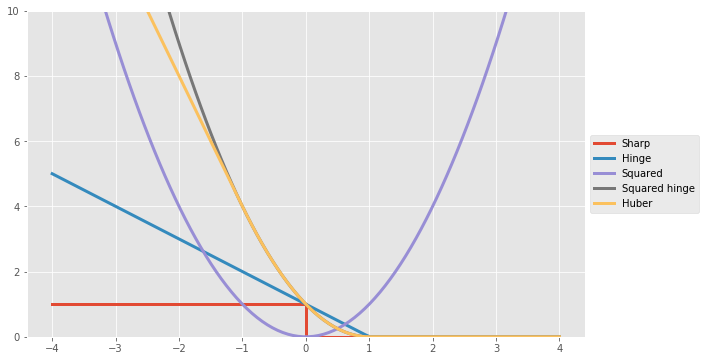

In [44]:
afx.loss_functions()

La elección de la función de pérdida a optimizar dependerá del criterio de optimización (desviación o pérdida exponencial) y de la naturaleza del vector objetivo. Posteriormente revisaremos cómo `sklearn.ensemble.GradientBoostingClassifier` infiere de manera adecuada la función de pérdida.

## Intuición sobre Gradient Boosting

> __Caveat__: Esta discusión se basa en Geron (2017).

Para ejemplificar la mecánica de Gradient Boosting, generaremos una simulación entre árboles que se entrenan en los errores residuales de la fase previa. La figura generada con `afx.gboost_stage_one` estamos en la primera iteración de nuestro ensamble. La figura izquierda representa el ajuste del modelo entrenado en el el residuo de los datos, mientras que en la derecha se presenta el comportamiento del modelo en los datos. Observamos a grandes rasgos que la interpolación de la función en los datos es idéntica.

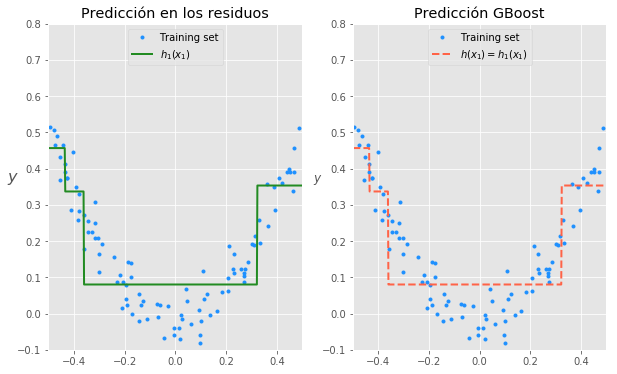

In [45]:
afx.gboost_stage_one()

En la segunda iteración del ensamble, el árbol se entrena en los residuos del árbol previo. En la figura derecha generada con `afx.gboost_stage_two`, la predicción en los datos de entrenamiento aumenta su exactitud en los datos, aumentando la capacidad de acoplarse en los datos. En la figura izquierda se observa que el entrenamiento de los datos tiende a suavizarse y a converger a cero. Este es un comportamiento deseable, teniendo en consideración que una buena característica de un estimador debe ser $\mathbb{E}[\bar\varepsilon_{i}=0]$.

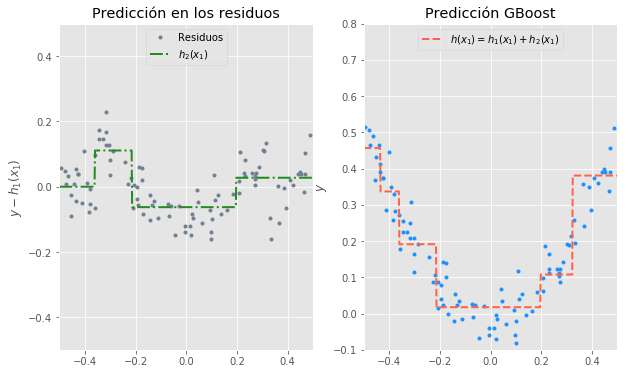

In [46]:
afx.gboost_stage_two()

La tercera iteración del ensamble presenta la particularidad que los residuos y la función objetivo acoplada en los residuos tiende a situarse cercano a cero. Esto se traduce en que el acople de la función Gradient Boost se acerca aún más a la distribución de los datos.

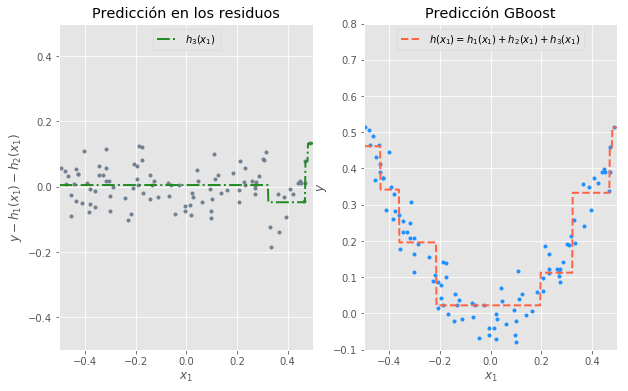

In [47]:
afx.gboost_stage_three()

## Implementación básica de un algoritmo `sklearn.ensemble.GradientBoostingClassifier`


De manera similar a como lo hemos realizado con otros modelos de `sklearn`,  debemos incorporar por lo menos tres elementos: un modelo, un preprocesador y una métrica de evaluación. Nuestro primer modelo que corresponde a un benchmark no tiene modificación en los hiperparámetros. Al entrenarlo y solicitar las métricas, observamos que presenta un aumento de 2% en la capacidad predictiva en comparación a la misma implementación de AdaBoost (medida con f1).

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boost_model = GradientBoostingClassifier().fit(X_train, y_train)
y_hat = gradient_boost_model.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       912
           1       0.94      0.93      0.94       607

   micro avg       0.95      0.95      0.95      1519
   macro avg       0.95      0.95      0.95      1519
weighted avg       0.95      0.95      0.95      1519



Por defecto, los estimadores implementados en Gradient Boosting corresponden a árboles de regresión con un máximo de profundidad de 3. Se implementan árboles de regresión dado que nos permite perfilar de una mejor manera el comportamiento del error. Los hiperparámetros que controlan el comportamiento de los árboles se pueden definir dentro de la función `sklearn.ensemble.GradientBoostingClassifier`.

In [49]:
gradient_boost_model.estimators_[0][0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x105f3a990>,
           splitter='best')

¿Qué es lo que provoca este aumento en la capacidad predictiva del modelo? Partamos por analizar el principio de optimización de la función de pérdida.

## Función de pérdida

La función de pérdida a optimizar responde a dos dimensiones: La naturaleza del vector objetivo y el forma de la función de pérdida. En nuestro modelo benchmark implementamos el criterio de `deviance`, en parte porque la opción `exponential` retorna lo mismo que AdaBoost. `scikit-learn` infiere de forma automática el criterio, en este caso `BinomialDeviance`. En la literatura tiene otros nombres como logLoss o entropía cruzada. Podemos solicitar el tipo de función de pérdida a implementar en el modelo con la siguiente línea

In [50]:
print(type(gradient_boost_model.loss_))

<class 'sklearn.ensemble.gradient_boosting.BinomialDeviance'>


Ahora procederemos a visualizar cómo cada estimador secuencial reduce el error. Para ello necesitamos evaluar la función de pérdida en cada uno de los estimadores. Esto lo lograremos con la función `afx.profile_loss_function`, que nos entregará el declive en la función en cada estimador, así como la cantidad de estimadores óptimos que reducen la función.

Text(0, 0.5, 'Test BinomialDeviance')

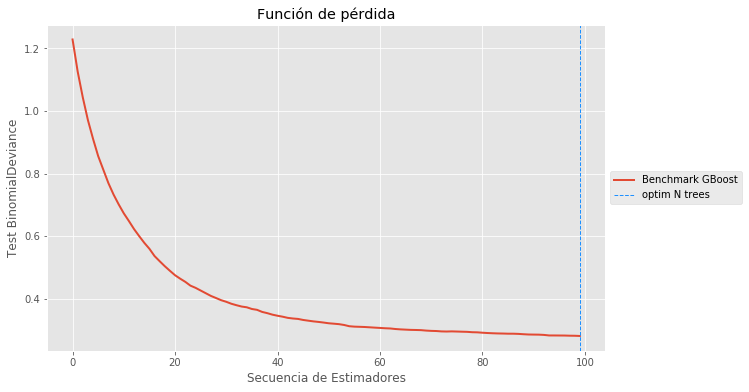

In [51]:
# extraemos la función evaluada y el óptimo
gb_loss_1, optim = afx.profile_loss_function(gradient_boost_model, X_test, y_test)
plt.plot(gb_loss_1, label = 'Benchmark GBoost', lw=2)
plt.axvline(optim, label='optim N trees', lw=1, linestyle='--', color='dodgerblue')
plt.legend(loc='center left', bbox_to_anchor=(1, .5))
plt.title('Función de pérdida')
plt.xlabel('Secuencia de Estimadores')
plt.ylabel('Test BinomialDeviance')

Observamos que cuando implementamos un algoritmo Gradient Boosting con 100 estimadores (la especificación por defecto en `sklearn.ensemble.GradientBoostingClassifier`), el número óptimo se sitúa al final. Esto genera evidencia a favor de aumentar la cantidad de estimadores a agregar en el algoritmo.

Revisemos el comportamiento de la exactitudo en las predicciones del modelo. Se observa el hecho que tanto en el testing como training set logra un excelente desempeño que no distan entre sí.

In [52]:
print("Exactitud Gboost en Testing: ", gradient_boost_model.score(X_test, y_test).round(3))
print("Exactitud Gboost en Training: ", gradient_boost_model.score(X_train, y_train).round(3))

Exactitud Gboost en Testing:  0.949
Exactitud Gboost en Training:  0.964


## Hiperparámetros asociados a Gradient Boosting

`sklearn.ensemble.GradientBoostingClassifier` contiene una cantidad no menor de hiperparámetros que se pueden agrupar en tres clases: Hiperparámetros que controlan los árboles de decisión, hiperparámetros que controlan el funcionamiento del ensamble secuencial e hiperparámetros que controlan la forma funcional.

Ya sabemos el funcionamiento de los árboles de decisión y por tanto no profundizaremos sobre su comportamiento en el contexto de Gradient Boosting. Lo único que debemos tener en consideración es que por defecto los clasificadores implementados corresponden a árboles de regresión con una profundidad de 3 (`sklearn.tree.DecisionTreeClassifier(max_depth=3)`).

También sabemos sobre el efecto de la cantidad de estimadores y la tasa de aprendizaje en el ensamble. Cuando nuestra tasa de aprendizaje sea más alta, cada estimador dentro del ensamble tendrá un rol más fuerte para corregir los errores de estimadores previos. Éstos elementos controlan la frecuencia de actualización de la gradiente de la función de pérdida. Si bien el algoritmo es relativamente robusto ante una gran cantidad de estimadores en el ensamble, existe la posibilidad de overfitting, por lo que se sugiere buscar su número óptimo mediante validación cruzada.

El efecto de la tasa de aprendizaje en la optimización de la función de pérdida se visualiza en la figura generada con `afx.gboost_learning_hyperparams`. Podemos diferenciar entre dos tipos de comportamientos: aquellos ineficientes que tienden a maximizar la pérdida cuando la tasa de aprendizaje es alta y aquellos que con una tasa de aprendizaje más baja presentan un comportamiento más estable en la reducción de la pérdida.

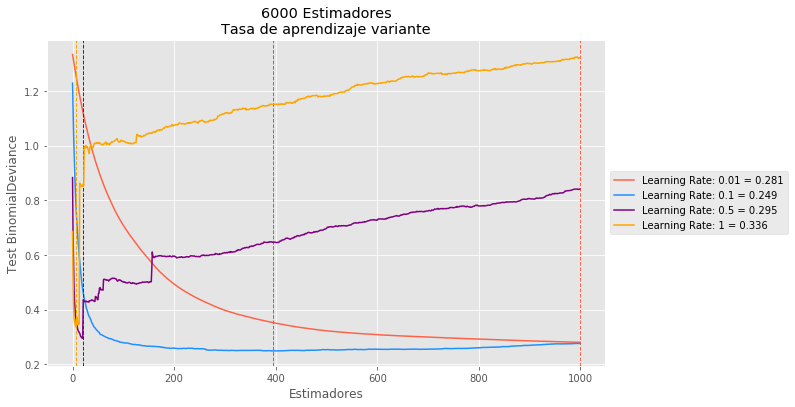

In [53]:
afx.gboost_learning_hyperparams(X_train, X_test, y_train, y_test)

¿Qué puede explicar ésto? Resulta que cuando las tasas de aprendizaje son muy altas, pueden ignorar el óptimo de la función de pérdida. En oposición al comportamiento de las tasas de aprendizaje bajas. Si bien alcanzan un óptimo de forma más lenta, nos aseguran que éste tendrá una mayor validez.

### Subsample en el entrenamiento

El hiperparámetro importante a considerar en el caso de Gradient Boosting es la fracción de observaciones seleccionadas en cada estimador entrenado. La selección de ésto se realiza mediante muestreo aleatorio. En la medida que nuestra fracción de casos a considerar en la muestra de entrenamiento disminuye, disminuímos la varianza del modelo entrenado y aumentamos su capacidad de generalización. Valores entre .8 y 1 generalmente dan buenos resultados en el desempeño.

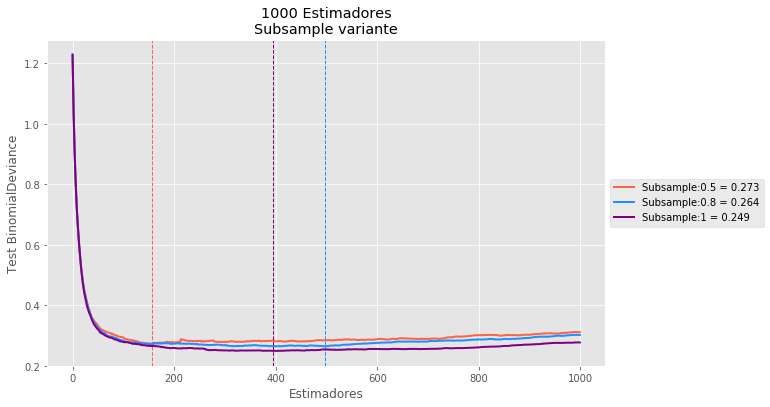

In [54]:
afx.gboost_sampling_hyperparams(X_train, X_test, y_train, y_test)

## Búsqueda de hiperparámetros en Gradient Boosting

Cabe destacar que dado la tendencia a generar predicciones con un gran desempeño, Gradient Boosting puede sufrir de overfitting. Para ello se requiere encontrar la mejor combinación de hiperparámetros mediante grilla. En este experimiento evaluaremos el desempeño del modelo con las siguientes especificaciones.


| Hiperparámetro | Especificación|
|----------------|---------------|
|Cantidad de estimadores secuenciales `n_estimators` | 100, 500, 1000 | 
| Tasa de Aprendizaje `learning_rate` | 0.01, 0.1, 0.5, 1, 5, 10 | 
| Subsample `subsample` | 5 pasos entre 10% al 100% | 

In [55]:
param_grid = {'n_estimators': [100, 500, 1000],
             'learning_rate': [0.01, 0.1, 0.5, 1, 5, 10],
             'subsample': np.linspace(0.1, 1.0, 5, endpoint=True, dtype=float),
             }

In [56]:
from sklearn.model_selection import GridSearchCV

gb_grid = GridSearchCV(GradientBoostingClassifier(),
                      param_grid = param_grid,
                      cv=5, n_jobs=-1).fit(X_train, y_train)

En comparación a la primera iteración del modelo, observamos un aumento en 1% en la capacidad predictiva (medida con f1). Si bien es un aumento marginal, también podemos evaluar el comportamiento con curvas ROC. En este caso, el modelo presenta una área bajo la curva de 99%, en comparación a AdaBoost (97.4%).

In [57]:
y_hat = gb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       912
           1       0.94      0.95      0.95       607

   micro avg       0.96      0.96      0.96      1519
   macro avg       0.95      0.96      0.95      1519
weighted avg       0.96      0.96      0.96      1519



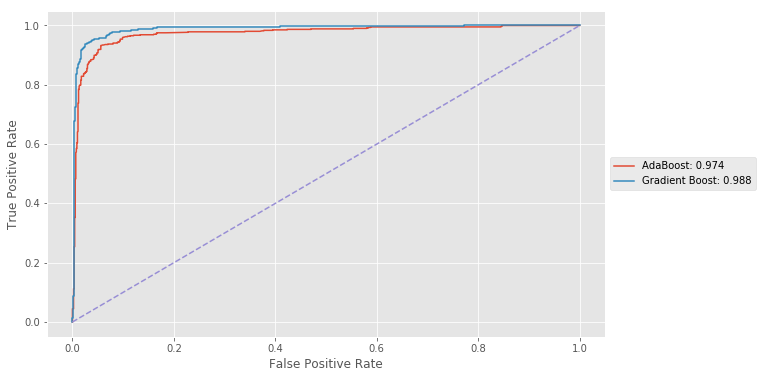

In [58]:
afx.plot_roc(model=adaboost_model, y_true= y_test, X_test=X_test,model_label="AdaBoost")
afx.plot_roc(model=gb_grid.best_estimator_, y_true= y_test, X_test=X_test,model_label="Gradient Boost")
plt.plot([0, 1], ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, .5))

## Aspectos adicionales

### Aspectos prácticos

Dado Gradient Boosting y Random Forest funcionan bien en un mismo conjunto de datos, por lo general la práctica es entrenar un modelo Random Forest, que funciona bien de manera robusta. Si deseamos implementar nuestro modelo en producción y mejorar el tiempo de predicción, podemos utilizar Gradient Boosting para ello.

### Pros

* Estos también se pueden considerar algoritmos _off-the-shelf_ en el sentido que no es necesario generar mucho preprocesamiento o feature engineering de los datos.

* Murphy (2012, pp.564) sugiere que los algoritmos de Boosting funciona muy bien, en específico para los clasificadores. Existen dos razones principales/ En primer lugar puede ser entendido como una forma de regularización $\ell_{1}$, que permite reducir overfitting mediante la eliminación de atributos "irrelevantes" en el modelo. Si tenemos un vector de atributos entrenados de forma aditiva $f(\mathbf{x}) = [f_{1}(\mathbf{x}), f_{2}(\mathbf{x}), \cdots, f_{M}(\mathbf{x})]$, $\ell_{1}$ puede ir probando su tolerancia. Otra explicación es que AdaBoost maximiza el márgen separador en los datos de entrenamiento.

### Cons

* Una de las principales desventajas es el tiempo de entrenamiento de los modelos Boosting y la necesidad de ajustar de forma correcta los hiperparámetros asociados.
* Tampoco funcionan muy bien en problemas con altas dimensiones.

### XGBoost: eXtreme Gradient Boosting

Ante la eventualidad de encontrarse con una gran cantidad de datos, una buena alternativa es utilizar la implementación `xgboost` en Python. Ésta tiene la ventaja de tener un desempeño más rápido en el tiempo de entrenamiento que la implementación vista con `scikit-learn`.



### Apéndice: Formalización de Descenso de Gradiente y el algoritmo Gradient Boosting

> __Caveat:__ La exposición formal del algoritmo Gradient Boosting necesita de conocimientos básicos sobre optimización y gradientes. La presentación del algoritmo sigue la exposición de Freund y Schapire (2012), Hastie et al. (2009) y Murphy (2012).

Teniendo en consideración que nuestra estrategia de optimización es reducir la pérdida del modelo, podemos analizar el comportamiento predictivo de la función $\hat{y} = f(x)$ en el conjunto de entrenamiento:

$$
\ell(f) = \sum_{i=1}^{N}\ell(y_{i}, f(x_{i}))
$$

El problema de optimización a resolver tiene la siguiente forma canónica:

$$
\hat{\boldsymbol f} = \underset{\boldsymbol f}{\textsf{argmin}} \ell (\boldsymbol f)
$$

donde los parámetros a optimizar $\boldsymbol f \in \mathbb{R}^{N}$ corresponden a los valores de las funciones de aproximación $f(x_{i})\> \forall x_{i} \in N$.

El procedimiento de optimización numérica para resolver $\ell(f) = \sum_{i=1}^{N}\ell(y_{i}, f(x_{i}))$ sigue una suma de vectores de los componentes

$$
\hat{\boldsymbol f}_{M} = \sum_{m=0}^{M}\boldsymbol h_{m}, \quad \forall \boldsymbol h_{m} \in \mathbf{R}^{N}
$$

donde debemos tener un parámetro inicial en $\boldsymbol h_{0}$. En cada $\boldsymbol f_{m}$ posterior se induce en función a su predecesor $\boldsymbol f_{m-1}$, que representa la suma de las actualizaciones previas.

El máximo descenso elige respecto a $\boldsymbol h_{m} = -\rho_{m}\nabla_{m}$, donde $\rho_{m}$ es un escalar que representa el largo de los pasos a actualizar en la función de pérdida y $\nabla_{m} \in \mathbb{R}^{N}$ es el gradiente de $\ell(\boldsymbol f)$ evaluado en $\boldsymbol f = \boldsymbol f_{m-1}$. 

Para obtener $\rho_{m}$ óptimo, debemos solucionar el siguiente problema de minimización

$$
\rho_{m} = \underset{\rho}{\textsf{argmin}}\ell(\boldsymbol f_{m-1} - \rho \nabla_{m})
$$


Los componentes del gradiente son:

$$
\nabla_{im} = - \Big[ \frac{\partial \ell (y_{i}, f(\mathbf{x}_{i}))}{\partial f\mathbf{x}_{i}}\Big]_{f(\mathbf{x}_{i}) = f_{m - 1}(\mathbf{x}_{i})}  
$$

El proceso se repite hasta que se minimice la dirección local de $\rho$.




> #### Algoritmo: Gradient Boosting
>
> 1. El primer paso es inicializar la función $f_{0}(\mathbf{x}) = \underset{\gamma\in\Gamma}{\textsf{argmin}}\sum_{i=1}^{N}\ell(y_{i}, \phi(\mathbf{x}_{i}, \gamma)$
> - Para cada clasificador débil en nuestro ensamble $m \in M$:
>    - Obtener el descenso de gradiente de la función $f$ en los residuos respecto a la iteración previa $f_{m-1}$:
> $r_{im} = - \Big[ \frac{\partial \ell (y_{i}, f(\mathbf{x}_{i}))}{\partial f\mathbf{x}_{i}}\Big]_{f(\mathbf{x}_{i} = f_{m - 1}(\mathbf{x}_{i})}$   
>    - Utilizamos un clasificador débil para obtener $\gamma_{m}$ que minimice $\sum_{i=1}^{N}(r_{im} - \phi(\mathbf{x}_{i}, \gamma_{m}))^{2}$    
>    - Antes de proseguir con el siguiente clasificador débil, se actualiza la función $f_{m}(\mathbf{x}_{i}) = f_{m-1}(\mathbf{x}) + \nu \phi(\mathbf{x}_{i}, \gamma_{m})$ 
> - Resultado: $f(\mathbf{x}) - f_{M}(\mathbf{x})$


---

## Referencias

* Hastie, T; Tibshirani, R; Friedman, J. 2008. The Elementos fo Statistical Learning. Data Mining, Inference, and Prediction. New York: Springer.
* Murphy, K. 2012. Machine Learning. A Probabilistic Perspective. Cambridge, MA: Massachusetts Institute of Technology Press. Ch 16: Adaptive basis function models
* Wolpert, D y MacReady. 1997. No free lunch theorems for optimization. IEEE transactions on evolutionary computation 1 (1), 67-82
* Schapire, R.E. y Freund, Y., 2012. Boosting: Foundations and algorithms. MIT press.
* Zhou, 2012. Ensembles Methods. Foundations and Algorithms.